# Feature experimentation & EDA

In this notebook, I document my process of cleaning and formatting the data, Feature Engineering and Exploratory Data Analysis. This is the final version of the multiple iterations made during experimentation of my data processing process.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Loading File and Flattening JSON 

In [2]:
import json

# Converting JSON encoded data into Python dictionary
with open(r"Data\Collated_Data_170622_modified", "r") as read_file:
    data = json.load(read_file)

In [3]:
# Flatten nested JSON
data_flattened = pd.json_normalize(data, 'transaction', ['street','project','x','y','marketSegment'], errors = 'ignore')

data_flattened

,area,floorRange,noOfUnits,contractDate,typeOfSale,price,propertyType,district,typeOfArea,tenure,nettPrice,street,project,x,y,marketSegment
0,524.3,-,1,0220,3,5500000,Semi-detached,05,Land,Freehold,NaN,ZEHNDER ROAD,LANDED HOUSING DEVELOPMENT,22734.9253,29502.42071,RCR
1,308,-,1,0918,3,5000000,Semi-detached,05,Land,Freehold,NaN,ZEHNDER ROAD,LANDED HOUSING DEVELOPMENT,22734.9253,29502.42071,RCR
2,314,-,1,0618,3,4750000,Semi-detached,05,Land,Freehold,NaN,ZEHNDER ROAD,LANDED HOUSING DEVELOPMENT,22734.9253,29502.42071,RCR
3,308,-,1,0921,3,5200000,Semi-detached,05,Land,Freehold,NaN,ZEHNDER ROAD,LANDED HOUSING DEVELOPMENT,22734.9253,29502.42071,RCR
4,257,-,1,0522,3,4600000,Terrace,05,Land,Freehold,NaN,NEO PEE TECK LANE,LANDED HOUSING DEVELOPMENT,20914.1988965525,30589.1070785135,RCR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134725,304.1,-,1,0422,3,3430000,Terrace,27,Land,Freehold,NaN,GOODLINK PARK,GOODLINK PARK,27055.8704803037,45402.904304065,OCR
134726,268.2,-,1,1017,3,2480000,Terrace,27,Land,Freehold,NaN,GOODLINK PARK,GOODLINK PARK,27055.8704803037,45402.904304065,OCR
134727,215,01-05,1,0819,3,1100000,Apartment,27,Strata,Freehold,NaN,GOODLINK PARK,GOODLINK PARK,27055.8704803037,45402.904304065,OCR
134728,295.3,-,1,0921,3,3400000,Terrace,27,Land,Freehold,NaN,GOODLINK PARK,GOODLINK PARK,27055.8704803037,45402.904304065,OCR


## Handling Missing Data 

In [126]:
data_flattened.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134730 entries, 0 to 134729
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   area           134730 non-null  object
 1   floorRange     134730 non-null  object
 2   noOfUnits      134730 non-null  object
 3   contractDate   134730 non-null  object
 4   typeOfSale     134730 non-null  object
 5   price          134730 non-null  object
 6   propertyType   134730 non-null  object
 7   district       134730 non-null  object
 8   typeOfArea     134730 non-null  object
 9   tenure         134730 non-null  object
 10  nettPrice      452 non-null     object
 11  street         134730 non-null  object
 12  project        134730 non-null  object
 13  x              133606 non-null  object
 14  y              133606 non-null  object
 15  marketSegment  134730 non-null  object
dtypes: object(16)
memory usage: 16.4+ MB


Looking at the above breakdown, I observed that there were null values for "nettprice", "x" and "y". With a further check using **pd.unique()**, I found that some rows had missing "floorRange" values recorded as "-", and missing "tenure" values recorded as "NA".

**floorRange:**
Most of the missing data came from Terrace, Semi-detached and Detached property types, with a few Condominiums and Apartments. I have hence decided to impute "01-05" for all the missing values.

**Tenure and x-y coordinates:**
For rows with missing tenure and x-y coordinate values, I have decided to drop them completely.

**nettPrice:**
I have also decided to disregard the nettprice column in my analysis since most of the data is missing.

In [4]:
# Imputing missing floorRange values
data_flattened.loc[(data_flattened["floorRange"]=="-"), "floorRange"] = "01-05"

# Dropping rows and columns
data_removeNa = data_flattened[(pd.isna(data_flattened["x"]) != True) &
                               (pd.isna(data_flattened["y"]) != True) & 
                               (data_flattened["tenure"] != "NA")]
dataframe_2 = data_removeNa.drop("nettPrice", axis=1)

## Filtering Data

I made the following filters to the data for various reasons:
- **typeOfSale**: I decided to train the model to only predict prices for a normal property purchase to reduce the complexity of the analysis. Hence I removed the rows for “typeOfSale” == “2”, to exclude Sub-Sales.
- **noOfUnits**: I decided to exclude bulk sales from my analysis, since I wanted to train my model to predict prices of a transaction involving one property only. Hence I only included the rows for “noOfUnits” == “1”.

In [5]:
data_filtered = dataframe_2[(data_flattened["noOfUnits"] == "1") &
                            (data_flattened["typeOfSale"] != "2") &
                            (data_flattened["typeOfSale"] != np.nan)]
data_filtered_reindexed = data_filtered.reset_index()
data_filtered_reindexed

C:\Users\Roydon\AppData\Local\Temp\ipykernel_11960\1980083062.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_filtered = dataframe_2[(data_flattened["noOfUnits"] == "1") &


,index,area,floorRange,noOfUnits,contractDate,typeOfSale,price,propertyType,district,typeOfArea,tenure,street,project,x,y,marketSegment
0,0,524.3,01-05,1,0220,3,5500000,Semi-detached,05,Land,Freehold,ZEHNDER ROAD,LANDED HOUSING DEVELOPMENT,22734.9253,29502.42071,RCR
1,1,308,01-05,1,0918,3,5000000,Semi-detached,05,Land,Freehold,ZEHNDER ROAD,LANDED HOUSING DEVELOPMENT,22734.9253,29502.42071,RCR
2,2,314,01-05,1,0618,3,4750000,Semi-detached,05,Land,Freehold,ZEHNDER ROAD,LANDED HOUSING DEVELOPMENT,22734.9253,29502.42071,RCR
3,3,308,01-05,1,0921,3,5200000,Semi-detached,05,Land,Freehold,ZEHNDER ROAD,LANDED HOUSING DEVELOPMENT,22734.9253,29502.42071,RCR
4,4,257,01-05,1,0522,3,4600000,Terrace,05,Land,Freehold,NEO PEE TECK LANE,LANDED HOUSING DEVELOPMENT,20914.1988965525,30589.1070785135,RCR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131733,134725,304.1,01-05,1,0422,3,3430000,Terrace,27,Land,Freehold,GOODLINK PARK,GOODLINK PARK,27055.8704803037,45402.904304065,OCR
131734,134726,268.2,01-05,1,1017,3,2480000,Terrace,27,Land,Freehold,GOODLINK PARK,GOODLINK PARK,27055.8704803037,45402.904304065,OCR
131735,134727,215,01-05,1,0819,3,1100000,Apartment,27,Strata,Freehold,GOODLINK PARK,GOODLINK PARK,27055.8704803037,45402.904304065,OCR
131736,134728,295.3,01-05,1,0921,3,3400000,Terrace,27,Land,Freehold,GOODLINK PARK,GOODLINK PARK,27055.8704803037,45402.904304065,OCR


## Data Processing and Feature Extraction

I had to ensure that the x and y coordinate data were in float format for model training. The code below converts all data to the correct format.

In [6]:
# Adding columns with area, price and coordinates values converted to numerical values
convert_numericals = data_filtered_reindexed.assign(num_area = pd.to_numeric(data_filtered_reindexed["area"]),
                                                    num_price = pd.to_numeric(data_filtered_reindexed["price"]),
                                                    float_x = pd.to_numeric(data_filtered_reindexed["x"], downcast="float"),
                                                    float_y = pd.to_numeric(data_filtered_reindexed["y"], downcast="float"))

I wanted to have a feature that could allow me to measure the value of all the different types of property with differnet types of tenure together. I decided to use the lease remaining to do this, with the assumption that the freehold properties have a current lease left value of 999 yrs.

Using the *'contractDate'*, '*tenure'* columns, I created a new feature, *'lease_left'*. In the process, I extracted the *'yr_transacted'* feature that I decided to use in model training as well, since I believe that it will help improve accuracy.

The code below does some manipulation of the columns, and calculates the *'lease_left'* by:
1. Calculating the number of years it has been around (difference between the year where lease begun and the year transacted)
2. Use above value to calculate the lease left (difference between total lease length and number of years since lease started)

In [7]:
# Tenure Feature Extraction

# Extracting Year Transacted from 'contractDate' col
date = convert_numericals["contractDate"]
date_string_retrieval_df = date.str.split(expand = True)
date_numeric = date_string_retrieval_df.assign(yr_num = pd.to_numeric(date_string_retrieval_df[0]))
convert_numericals = convert_numericals.assign(yr_transacted = 2000 + date_numeric["yr_num"]%100)

# Split String data in "tenure"
tenure = convert_numericals["tenure"]
tenure_str_retrieval = tenure.str.split(expand = True)

# Seperation of Leasehold and freehold
leasehold = tenure_str_retrieval[(tenure_str_retrieval[1] == "yrs")]
freehold = tenure_str_retrieval[(tenure_str_retrieval[0] == "Freehold")]

# Calculating Lease left
leasehold = leasehold.assign(lease_len = pd.to_numeric(leasehold[0]), 
                             lease_start = pd.to_numeric(leasehold[5]), 
                             yr_transacted = convert_numericals["yr_transacted"])
leasehold = leasehold.assign(lease_left = leasehold["lease_len"] - (leasehold["yr_transacted"] - leasehold["lease_start"]))

# Joining Leasehold and Freehold data back together
lease_var_table = pd.concat([freehold, leasehold], axis = 0)

# Assigning Freehold Properies lease_left values to be equal 999
lease_var_table['lease_left'] = lease_var_table['lease_left'].fillna(999)

lease_var_table = lease_var_table.sort_index()

# Joining temp dataframe back to main dataframe
processed_features = pd.concat([convert_numericals, lease_var_table["lease_left"]], axis=1)
selected_features = processed_features[["num_area", "floorRange", "yr_transacted", "propertyType",
                                        "lease_left", "float_x", "float_y", "num_price"]]
selected_features

,num_area,floorRange,yr_transacted,propertyType,lease_left,float_x,float_y,num_price
0,524.3,01-05,2020,Semi-detached,999.0,22734.925781,29502.419922,5500000
1,308.0,01-05,2018,Semi-detached,999.0,22734.925781,29502.419922,5000000
2,314.0,01-05,2018,Semi-detached,999.0,22734.925781,29502.419922,4750000
3,308.0,01-05,2021,Semi-detached,999.0,22734.925781,29502.419922,5200000
4,257.0,01-05,2022,Terrace,999.0,20914.199219,30589.107422,4600000
...,...,...,...,...,...,...,...,...
131733,304.1,01-05,2022,Terrace,999.0,27055.871094,45402.906250,3430000
131734,268.2,01-05,2017,Terrace,999.0,27055.871094,45402.906250,2480000
131735,215.0,01-05,2019,Apartment,999.0,27055.871094,45402.906250,1100000
131736,295.3,01-05,2021,Terrace,999.0,27055.871094,45402.906250,3400000


## Exploratory Data Analysis

<Figure size 576x720 with 0 Axes>

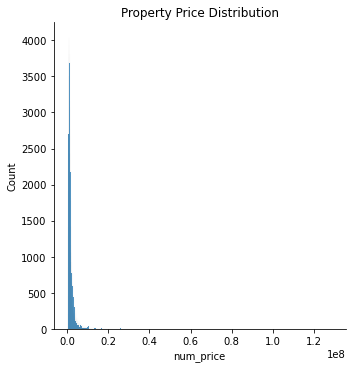

In [131]:
plt.figure(figsize=(8,10))
sns.displot(selected_features["num_price"])
title = plt.title("Property Price Distribution")

<Figure size 576x720 with 0 Axes>

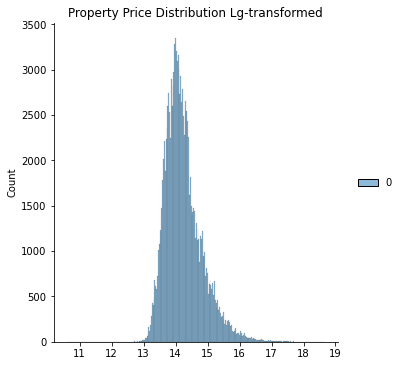

In [132]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

logTr = ColumnTransformer(transformers=[("lg", FunctionTransformer(np.log1p), ["num_price"])])
transformed_price = logTr.fit_transform(selected_features)

plt.figure(figsize=(8,10))
sns.displot(transformed_price)
plt.title("Property Price Distribution Lg-transformed")
plt.show()

Price is positively skewed as seen from the above plot. For the visualisation of the rest of the variables, I will be dropping the outliers with prices > $20,000,000 to better see patterns visually.

I made a copy of the *'selected_features'* table to apply filters to remove outliers for visualisation.

In [133]:
# Creating a copy of dataframe and dropping outliers for visualisation
vis_dataframe = selected_features.copy()
outlier_index = vis_dataframe[(vis_dataframe.num_price > .2*10**8)].index
vis_dataframe.drop(outlier_index, axis=0, inplace=True)
vis_dataframe = vis_dataframe.reset_index()

### Area

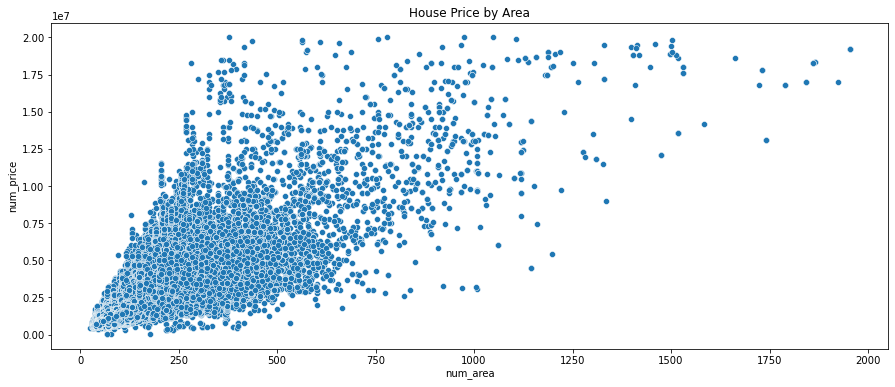

In [134]:
plt.figure(figsize=(15, 6))
sns.scatterplot(x='num_area', y='num_price', data=vis_dataframe)
title = plt.title('House Price by Area')

Generally, price increases as the floor area of the property increases.

### Floor Range

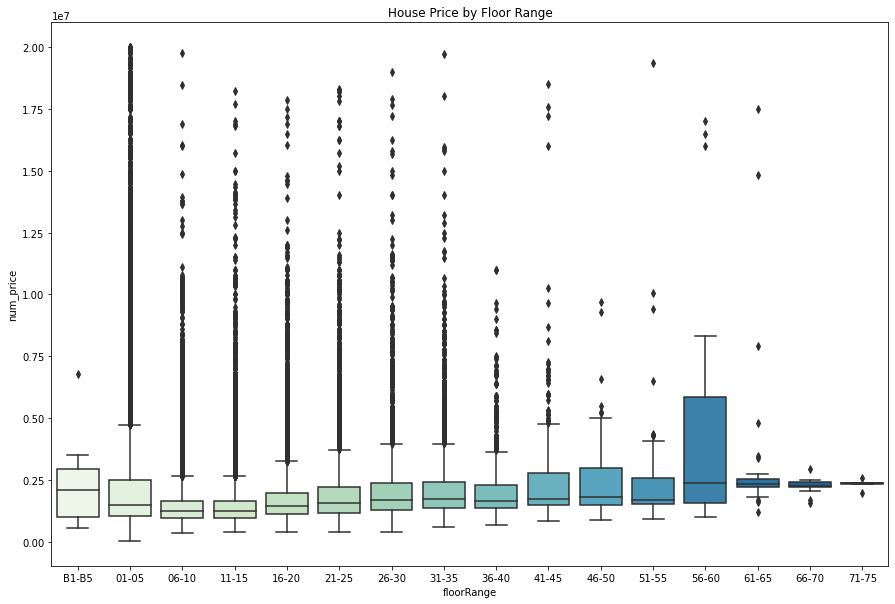

In [135]:
plt.figure(figsize=(15, 10))
sns.boxplot(x='floorRange',
            y='num_price',
            order=["B1-B5", "01-05", "06-10", "11-15", "16-20", "21-25", "26-30", "31-35", "36-40", "41-45",
                   "46-50", "51-55", "56-60", "61-65", "66-70", "71-75"],
            data=vis_dataframe, 
            palette='GnBu')
title = plt.title('House Price by Floor Range')

Generally, as the floor range increases, the price of the property also increases. Exceptions are Basement floors, and 01-05. This is likely due to there being more landed properties with this floor range.

### Property Type

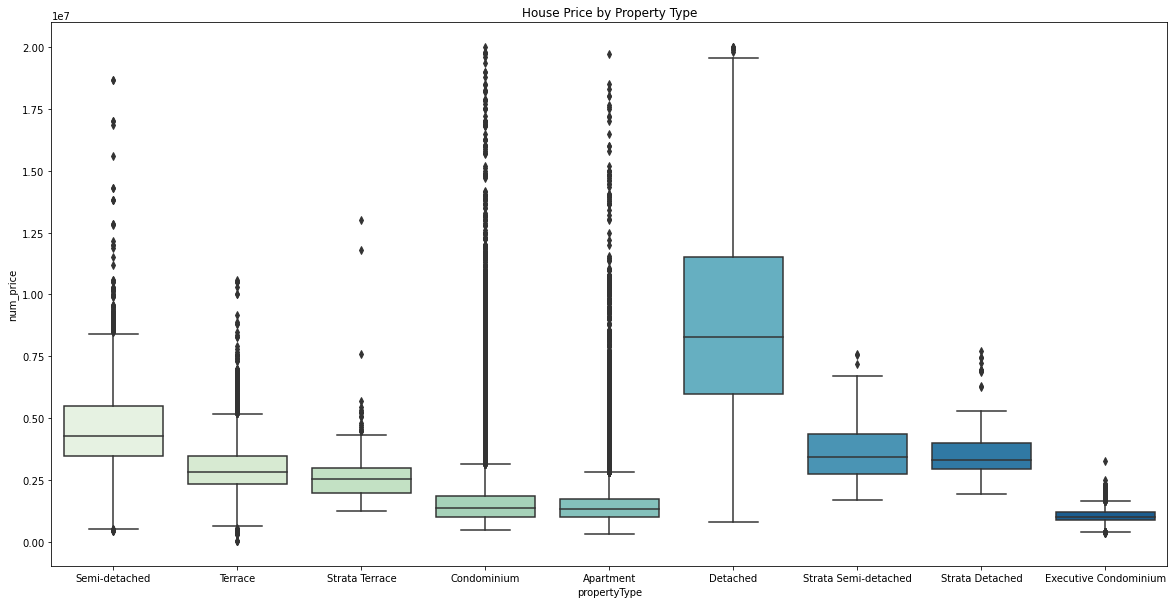

In [136]:
plt.figure(figsize=(20, 10))
sns.boxplot(x='propertyType',
            y='num_price',
            data=vis_dataframe,
            palette='GnBu')
title = plt.title('House Price by Property Type')

It is seen from this plot that the type of property does have a significant impact on the range of prices the property would fall in. I used the findings from this plot to label the *'propertyType'* feature with the Ordinal Encoder. 

### Location

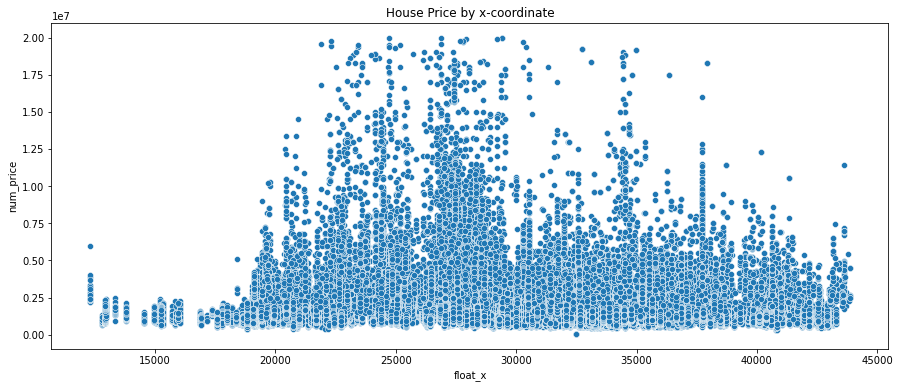

In [137]:
plt.figure(figsize=(15, 6))
sns.scatterplot(x='float_x', y='num_price', data=vis_dataframe)
title = plt.title('House Price by x-coordinate')

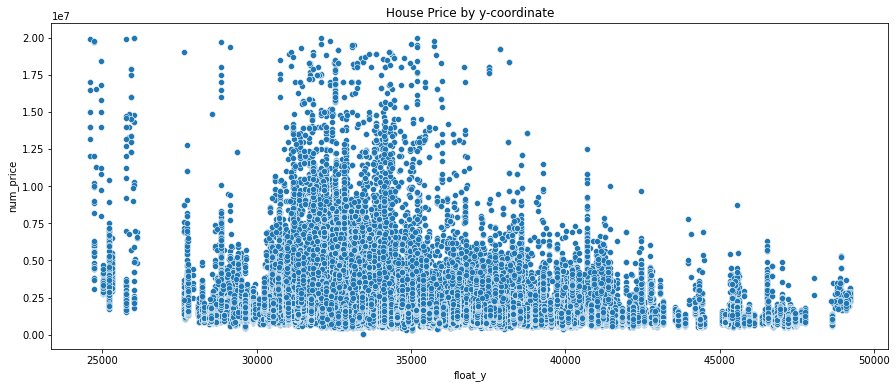

In [138]:
plt.figure(figsize=(15, 6))
sns.scatterplot(x='float_y', y='num_price', data=vis_dataframe)
title = plt.title('House Price by y-coordinate')

While visualising the x and y coordinate features seperately may not show relationships between location and price as clearly, I can still observe that prices tend to be higher South region (as seen from y-plot) and Central region of Singapore (as seen from x-plot). This could be due to proximity to the Central Business District in South and Central region of Singapore. The North and West regions appear to have lower prices according to the plots.

### Lease_left

In [139]:
outlier_index = vis_dataframe[(vis_dataframe.lease_left > 2000)].index
vis_dataframe.drop(outlier_index, axis=0, inplace=True)
vis_dataframe = vis_dataframe.reset_index()

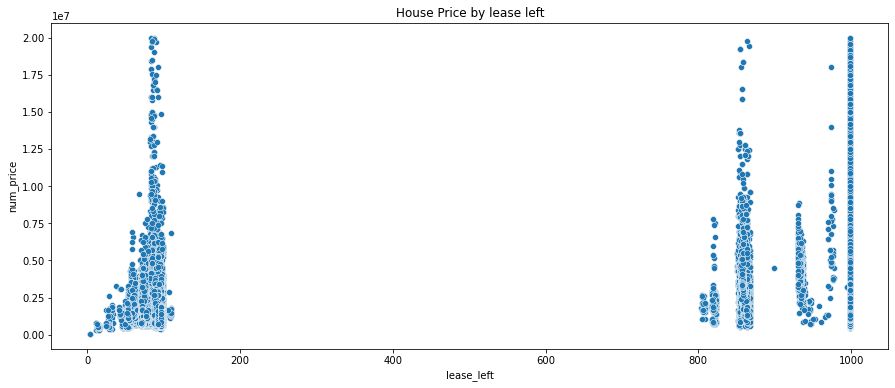

In [140]:
plt.figure(figsize=(15, 6))
sns.scatterplot(x='lease_left', y='num_price', data=vis_dataframe)
title = plt.title('House Price by lease left')

From the above plots, I observed that the lease_left feature is less informative when lease is > 100 years. Most of my data points fell between this period only, and there are many data points clustered at '999 yrs' lease_left since I have assumed all freehold properties to have '999 yrs' left earlier on. Even for other values above 800 years, data points are clustered at intervals instead of spreading across the whole range.

A lack of representation of different lease periods may cause this feature to not represent the relationships well. The model may not generalize well and prediction accuracy may be worse.

With this in consideration, I decided pivot the project to train the model with data points having a lease left between 0-100 yrs only.

## Encoding of Categorical Data

For categorical data columns: floorRange, yr_transacted and propertyType; I used the OrdinalEncoder from Sci-kit learn to encode them into numerical data formats.

In [8]:
from sklearn.preprocessing import OrdinalEncoder

floor_categories = ["01-05", "06-10", "11-15", "16-20", "21-25", "26-30", "31-35", "36-40",
                    "41-45", "46-50", "51-55", "56-60", "61-65", "66-70", "71-75", "B1-B5"]
type_categories = ["Executive Condominium", "Apartment", "Condominium", "Strata Terrace", "Strata Semi-detached",
                   "Strata Detached", "Terrace", "Semi-detached", "Detached"]

encoder = OrdinalEncoder(categories=[floor_categories, type_categories])
encoded = encoder.fit_transform(selected_features[['floorRange','propertyType']])
encoded_cols = pd.DataFrame(encoded)

add_encoded_cols = pd.concat([selected_features, pd.DataFrame(encoded)], axis=1)
processed_features = add_encoded_cols.rename(columns={0: 'floor_range', 1: 'property_type'})
final_features = processed_features.drop(["floorRange", "yr_transacted", "propertyType"], axis=1)

In [9]:
# Dropping of Landed properties and those with lease-left > 99 years
datasetWithoutLanded_df = final_features.copy()
outlier_index = datasetWithoutLanded_df[(datasetWithoutLanded_df.lease_left > 99) | 
                                        (datasetWithoutLanded_df.property_type > 5)].index
datasetWithoutLanded_df.drop(outlier_index, axis=0, inplace=True)
final_features = datasetWithoutLanded_df.reset_index(drop=True)
final_features

,num_area,lease_left,float_x,float_y,num_price,floor_range,property_type
0,194.0,85.0,28382.470703,25008.335938,2741000,0.0,2.0
1,224.0,84.0,28382.470703,25008.335938,3254850,0.0,2.0
2,224.0,84.0,28382.470703,25008.335938,4068160,0.0,2.0
3,194.0,85.0,28382.470703,25008.335938,2793790,0.0,2.0
4,199.0,84.0,28382.470703,25008.335938,3071880,0.0,2.0
...,...,...,...,...,...,...,...
84076,68.0,97.0,28390.146484,45560.437500,1029480,1.0,1.0
84077,72.0,97.0,28390.146484,45560.437500,1121420,0.0,1.0
84078,107.0,97.0,28390.146484,45560.437500,1417780,0.0,1.0
84079,58.0,97.0,28390.146484,45560.437500,880200,1.0,1.0


In [12]:
final_features.describe()

,num_area,lease_left,float_x,float_y,num_price,floor_range,property_type
count,84081.000000,84081.000000,84081.000000,84081.000000,8.408100e+04,84081.000000,84081.000000
mean,95.237403,91.035383,30046.769531,36397.250000,1.388614e+06,1.569463,1.317955
std,46.915027,8.888598,6962.295898,4863.214355,8.056621e+05,1.734873,0.737840
min,32.000000,16.000000,12779.295898,24730.345703,3.400000e+05,0.000000,0.000000
25%,65.000000,88.000000,24800.931641,32767.937500,9.550000e+05,0.000000,1.000000
50%,89.000000,95.000000,30267.726562,36358.550781,1.220000e+06,1.000000,1.000000
75%,113.000000,97.000000,35185.816406,39493.820312,1.590000e+06,2.000000,2.000000
max,1961.000000,99.000000,43274.605469,48642.828125,6.200000e+07,14.000000,5.000000


## Normalisation of Data and Correlation Analysis

In [14]:
y = final_features.num_price
x = final_features.drop(columns=['num_price'])

x_norm = (x - x.min()) / (x.max() - x.min())
x_norm

,num_area,lease_left,float_x,float_y,floor_range,property_type
0,0.083981,0.831325,0.511658,0.011625,0.000000,0.4
1,0.099533,0.819277,0.511658,0.011625,0.000000,0.4
2,0.099533,0.819277,0.511658,0.011625,0.000000,0.4
3,0.083981,0.831325,0.511658,0.011625,0.000000,0.4
4,0.086573,0.819277,0.511658,0.011625,0.000000,0.4
...,...,...,...,...,...,...
84076,0.018663,0.975904,0.511910,0.871097,0.071429,0.2
84077,0.020736,0.975904,0.511910,0.871097,0.000000,0.2
84078,0.038880,0.975904,0.511910,0.871097,0.000000,0.2
84079,0.013478,0.975904,0.511910,0.871097,0.071429,0.2


In [16]:
# Saving processed dataset into pickle file
data_std = pd.concat([x_norm, y], axis=1)
data_std.to_pickle("final_features.pkl")